## 1. Set-up

### Drive and Path

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#set file path
project_path = "/content/drive/MyDrive/266 Project/"
image_path = project_path+"pokemon_hf_png/"
caption_path = project_path+"pokemon_caption_hf.csv"

### Import libraries

In [ ]:
#libraries
import string, os, re, pickle
import numpy as np
import pandas as pd

from IPython.display import Image, display

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.layers import Embedding, Input, Dense, Lambda, BatchNormalization, LSTM, Dropout, RepeatVector, TimeDistributed, Bidirectional, add, concatenate
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical, plot_model


In [ ]:
!pip install aac-metrics
!aac-metrics-download
from aac_metrics import evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.8/161.8 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 14.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cach

Get data from Huggingface

In [ ]:
# !pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00


In [ ]:
# from datasets import load_dataset
# dataset = load_dataset("svjack/pokemon-blip-captions-en-zh", split='train')

# data = []

# for i in range(len(dataset)):
#   record_num = str(i+1)
#   dataset[i]['image'].save(image_path + record_num + '.png')
#   data.append([record_num,dataset[i]['en_text']])

# caption_df = pd.DataFrame(data, columns=['pokedex', 'caption'])

In [ ]:
# caption_df.to_csv(caption_path)

## 2. Image Feature Prep

In [ ]:
#check image count
imagename_df = pd.DataFrame(os.listdir(image_path))
imagename_df.columns = ['filename']
imagename_df['pokedex'] = imagename_df['filename'].str.replace('.png', "")
print("Total pokemon image = ", len(imagename_df))

Total pokemon image =  833


### Extract image feature with CNN: InceptionV3

In [ ]:
#function to extract features of images in the key list, stored in the image path
def extract_img_features(image_path, image_ids):

  #load InceptionV3 model and restructure to remove the classification layer
  img_model = InceptionV3()
  img_model = Model(inputs=img_model.inputs, outputs=img_model.layers[-2].output)

  #check model summary
  #print(img_model.summary())

  # extract features for each image in the key list
  img_features = {}

  for image_id in image_ids:

    #read the image file
    full_path = image_path + '/' + str(image_id) + '.png'

    #image preprocess for model
    image = load_img(full_path, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    #get feature and add to features dictionary
    img_feature = img_model.predict(image, verbose=0)
    img_features[image_id] = img_feature

  return img_features

In [ ]:
# extracting image features for all pokemon images
pokemon_img_features = extract_img_features(image_path, imagename_df.pokedex.values)

96112376/96112376 [==============================] - 5s 0us/step


In [ ]:
#check
print("{} : {}".format(list(pokemon_img_features.keys())[0], pokemon_img_features[list(pokemon_img_features.keys())[0]] ))
print(len(pokemon_img_features))

1 : [[2.4030704  1.7896745  9.726534   ... 2.9792671  0.21391262 0.09249075]]
833


In [ ]:
#save the feature to file in drive
pickle.dump(pokemon_img_features, open(project_path+'pokemon_img_features_hf.pkl', 'wb'))

In [ ]:
#load the feature from file in drive
pokemon_img_features = pickle.load(open(project_path+'pokemon_img_features_hf.pkl', 'rb'))

## 3. Prep captions and tokens

In [ ]:
#read caption file
caption_df = pd.read_csv(caption_path)
caption_df['pokedex'] = caption_df['pokedex'].astype(str)
caption_df['caption'] = 'startseq ' + caption_df['caption'].astype(str) + ' endseq'
caption_df.drop(caption_df.columns[[0]],axis=1,inplace=True)
caption_df.head()

,pokedex,caption
0,1,startseq a drawing of a green pokemon with red...
1,2,startseq a green and yellow toy with a red nos...
2,3,startseq a red and white ball with an angry lo...
3,4,startseq a cartoon ball with a smile on it's f...
4,5,startseq a bunch of balls with faces drawn on ...


###Tokenizer

In [ ]:
#Tokenize caption

tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(caption_df.caption.values))

#store the total length in vocab_len and add 1 because word_index starts with 1 not 0
vocab_size = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(row['caption'].split()) for index,row in caption_df.iterrows())

print("vocab_size: ", vocab_size)
print("max_len: ", max_len)

vocab_size:  361
max_len:  18


## 4. Baseline Model: CNN + LSTM

###Data split

In [ ]:
#training, testing data split

train_validate_caption, test_caption = train_test_split(caption_df, test_size = 83, random_state=123)

print('Number of train/validate records: ', len(train_validate_caption))
print('Number of test records: ', len(test_caption))

Number of train/validate records:  750
Number of test records:  83


###Generate input data for model

In [ ]:
def data_generator(img_keys, captions, img_features, tokenizer, max_length, vocab_size, batch_size):

  # loop over images to get image feature in X1, former sequence in X2 and latter sequence in y
  X1, X2, y = list(), list(), list()
  n = 0

  while 1:

    for img_key in img_keys:

      n += 1
      caption = captions[captions['pokedex']==img_key]['caption'].values[0]

      seq = tokenizer.texts_to_sequences([caption])[0]

      # split the sequence into X, y pairs
      for i in range(1, len(seq)):

        # split into input and output pairs
        in_seq, out_seq = seq[:i], seq[i]

        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

        # encode output sequence
        out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]

        # store the data records
        X1.append(img_features[img_key][0])
        X2.append(in_seq)
        y.append(out_seq)

      #yield and restart list if batch size is reached
      if n == batch_size:
          X1, X2, y = np.array(X1), np.array(X2), np.array(y)
          yield [X1, X2], y
          X1, X2, y = list(), list(), list()
          n = 0

###Model

In [ ]:
embedding = 50
lstm_unit = 256
dropout_rate = 0.2

# encoder
## image feature layers
input1 = Input(shape=(2048,))
if1 = Dropout(dropout_rate)(input1)
if2 = Dense(lstm_unit, activation='relu')(if1)
if3 = RepeatVector(max_len)(if2)

## sequence feature layers
input2 = Input(shape=(max_len,))
sf1 = Embedding(vocab_size, embedding, mask_zero=True)(input2)
sf2 = Dropout(dropout_rate)(sf1)
sf3 = LSTM(lstm_unit, return_sequences=True)(sf2)

# decoder
decoder1 = concatenate([if3, sf3])
decoder2 = Bidirectional(LSTM(lstm_unit, return_sequences=False))(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

baseline_model = Model(inputs=[input1, input2], outputs=outputs)
baseline_model.compile(loss='categorical_crossentropy', optimizer='adam')

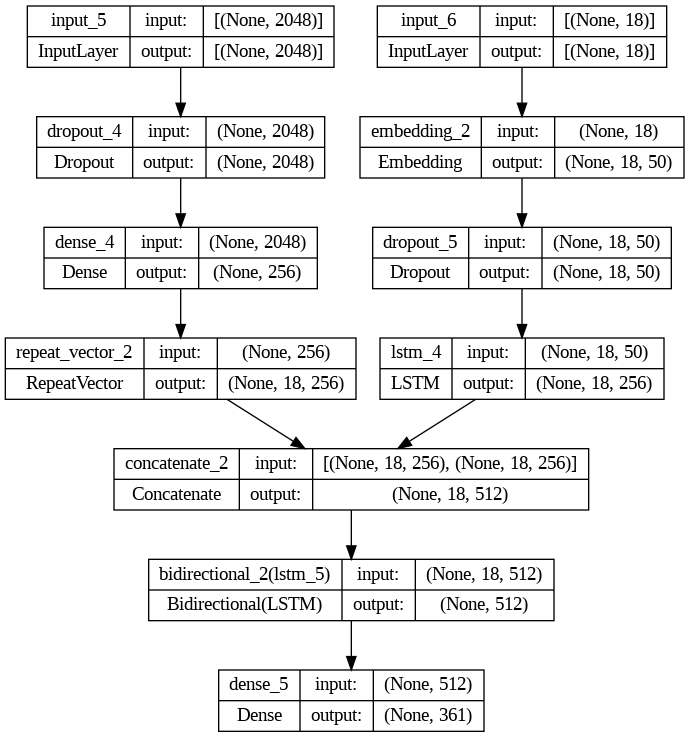

In [ ]:
# plot the model
plot_model(baseline_model, show_shapes=True)

### Model train / fit

In [ ]:
# train the model
epochs = 100
batch_size = 32
steps = len(train_validate_caption) // batch_size

for i in range(epochs):
    # use data generator
    generator = data_generator(train_validate_caption.pokedex.values, caption_df, pokemon_img_features, tokenizer, max_len, vocab_size, batch_size)
    # fit for one epoch
    baseline_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

23/23 [==============================] - 2s 78ms/step - loss: 0.4556


In [ ]:
# save the model for reuse
baseline_model.save(project_path + 'model_baseline_dataset2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#load saved model from file
baseline_model = load_model(project_path + 'model_baseline_dataset2.h5')

### Make prediction with test

In [ ]:
#function to return word from id from tokenizer
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
          return word
  return None

In [ ]:
#get caption for image from model prediction

def predict_caption(model, image, tokenizer, max_length):

  # add start tag
  in_text = 'startseq'

  # iterate over the max length of sequence
  for i in range(max_length):

    # encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence], max_length)

    # predict next word
    yhat = model.predict([image, sequence], verbose=0)
    # get index with high probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word(yhat, tokenizer)

    # stop if word not found
    if word is None:
        break

    #append word as input for generating next word
    in_text += " " + word

    # stop if we reach endseq tag
    if word == 'endseq':
        break

  return in_text

In [ ]:
def generate_caption(image_folder, image_id):

  # load the image
  display(Image(filename=image_folder + '/' + image_id + '.png'))

  #print actual caption
  print('---------------------Actual---------------------')
  print(caption_df[caption_df['pokedex']==image_id]['caption'].values[0])

  #print predicted caption
  print('--------------------Predicted--------------------')
  print(predict_caption(baseline_model, pokemon_img_features[image_id], tokenizer, max_len))

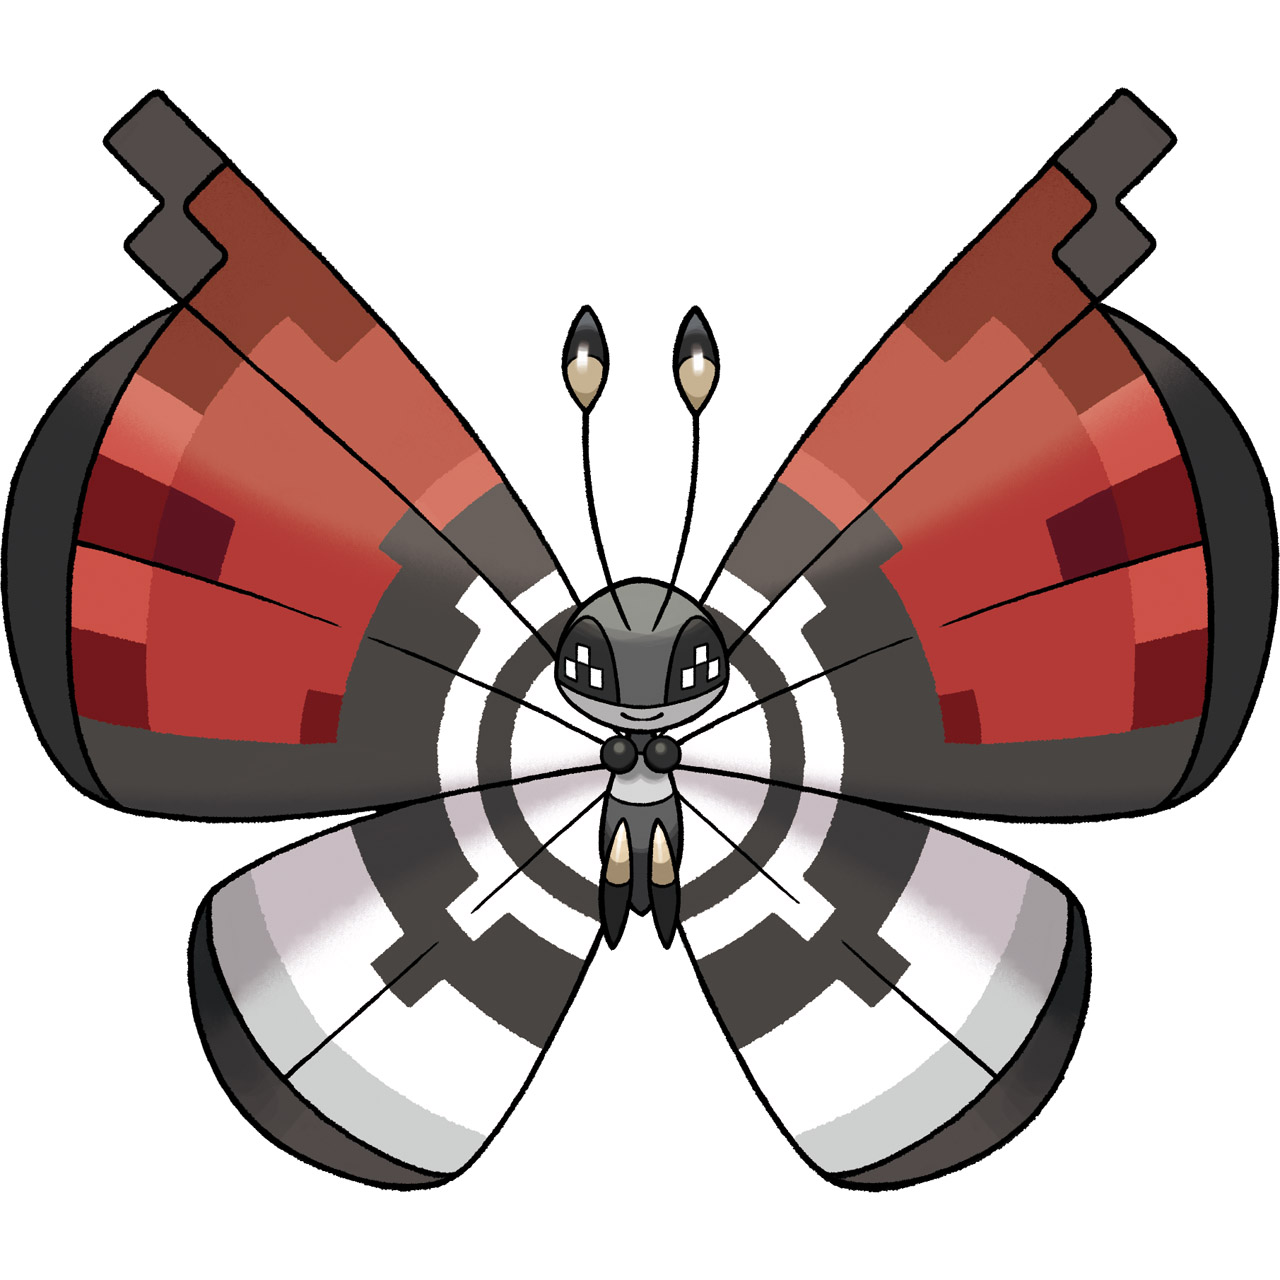

---------------------Actual---------------------
startseq a red and black butterfly sitting on top of a white background endseq
--------------------Predicted--------------------
startseq a blue and blue butterfly with a white background endseq


In [ ]:
generate_caption(image_path, "725")

##5. Validation

In [ ]:
#predict on test data

actual, predicted = list(), list()

for key in test_caption.pokedex.values:

  # get actual caption
  y_actual = caption_df[caption_df['pokedex']==key]['caption'].values[0].split()
  y_actual = y_actual[1:-1] #strip the startseq and endseq
  actual.append(' '.join(y_actual))

  # predict the caption for image
  y_pred = predict_caption(baseline_model, pokemon_img_features[key], tokenizer, max_len).split()
  y_pred = y_pred[1:-1] #strip the startseq and endseq
  predicted.append(' '.join(y_pred))

In [ ]:
#save the generated captions
generated_captions = pd.DataFrame(
    {'pokedex': test_caption.pokedex.values,
     'actual_caption': actual,
     'predicted_caption': predicted})

generated_captions.to_csv(project_path + 'generated_caption_baseline_dataset2.csv')

In [ ]:
#read from saved captions file
generated_captions = pd.read_csv(project_path + 'generated_caption_baseline_dataset2.csv')
actual = generated_captions.actual_caption.values
predicted = generated_captions.predicted_caption.values

In [ ]:
# calculate evaluation score
##input: list(), list(list(str))
##output: dict containing the score of each metric: "bleu_1", "bleu_2", "bleu_3", "bleu_4", "rouge_l", "meteor", "cider_d", "spice", "spider"

actual = [[item] for item in actual]
predicted = [item for item in predicted]

corpus_scores, _ = evaluate(predicted, actual)
print("bleu_1: ", corpus_scores["bleu_1"])
print("bleu_2: ", corpus_scores["bleu_2"])
print("bleu_3: ", corpus_scores["bleu_3"])
print("bleu_4: ", corpus_scores["bleu_4"])
print("rouge_l: ", corpus_scores["rouge_l"])
print("cider_d: ", corpus_scores["cider_d"])
print("spice: ", corpus_scores["spice"])

bleu_1:  tensor(0.4251, dtype=torch.float64)
bleu_2:  tensor(0.3196, dtype=torch.float64)
bleu_3:  tensor(0.2564, dtype=torch.float64)
bleu_4:  tensor(0.2035, dtype=torch.float64)
rouge_l:  tensor(0.4137, dtype=torch.float64)
cider_d:  tensor(0.7268, dtype=torch.float64)
spice:  tensor(0.1612, dtype=torch.float64)
